In [37]:
import numpy as np
import scipy as sp
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Inspect the input data: Zernike basis polynomials

In [2]:
Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)

In [3]:
Zcube.keys()
vmax = np.nanmax(np.array([np.nanmax(Zcube['Zpols'][0,it][5]) for it in range(45)]))
vmin = np.nanmin(np.array([np.nanmin(Zcube['Zpols'][0,it][5]) for it in range(45)]))


In [4]:
# Dimensions
Zcube['Zpols'][0,1][5].shape




(1024, 1024)

In [5]:
def resize_im(input_im, decim_f):  

    pil_im = PIL.Image.fromarray(input_im)
    (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
#     im_resized = pil_im.resize((width, height), resample=PIL.Image.LANCZOS)
    im_resized = pil_im.resize((width, height))
    
    return np.array(im_resized)


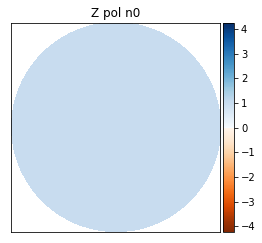

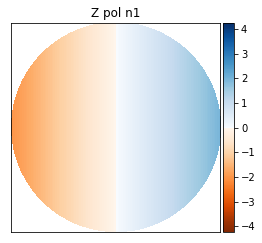

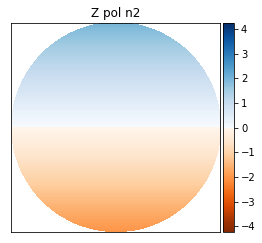

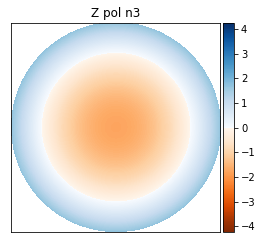

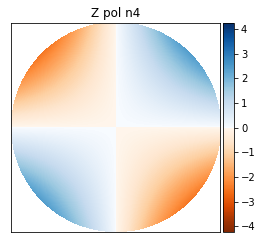

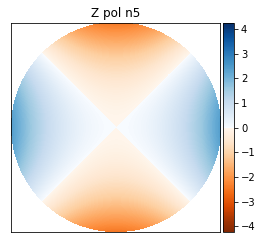

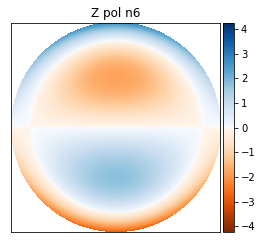

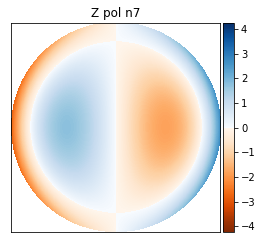

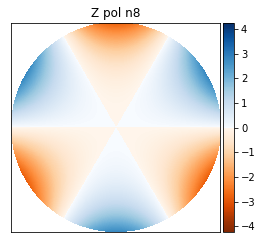

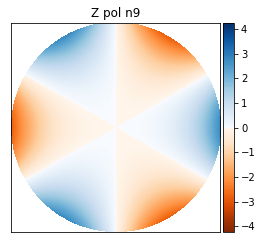

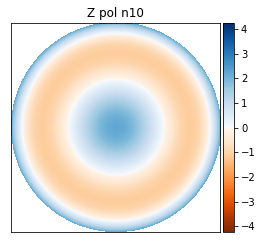

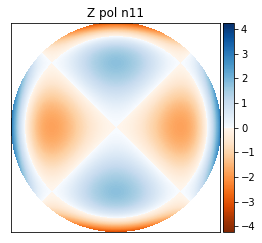

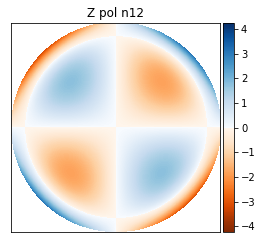

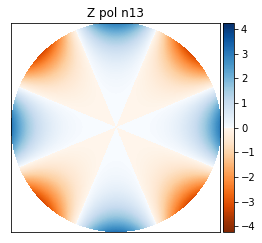

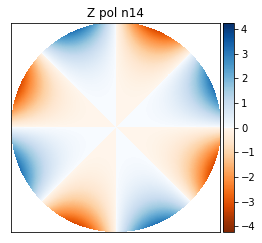

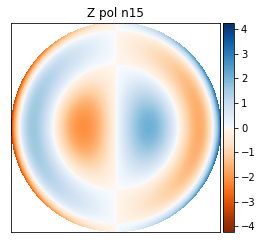

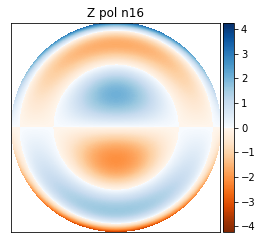

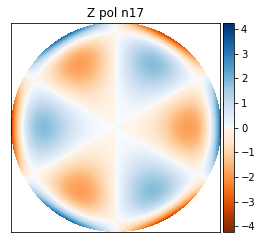

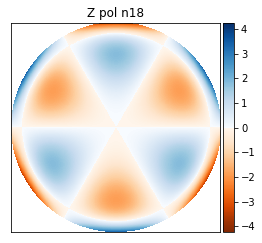

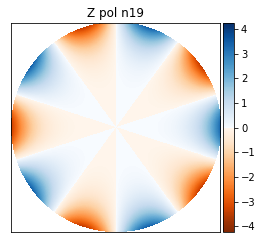

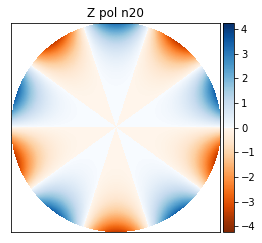

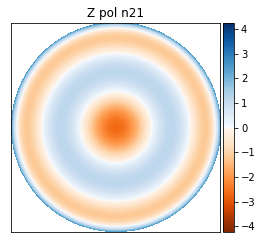

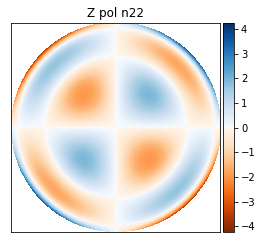

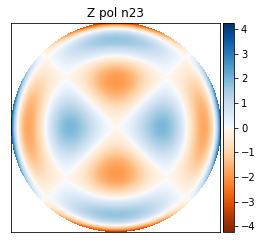

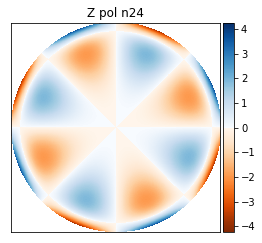

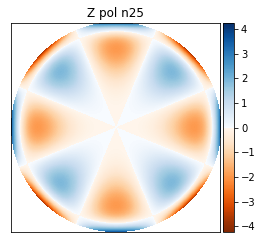

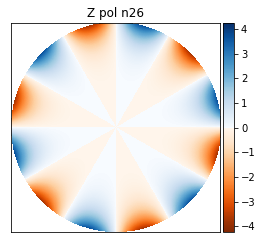

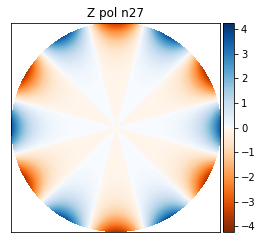

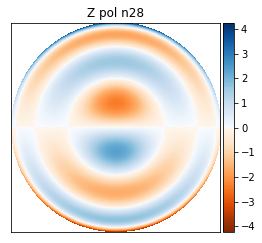

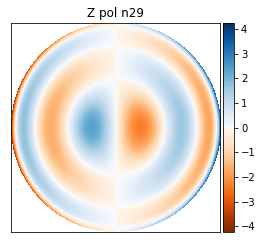

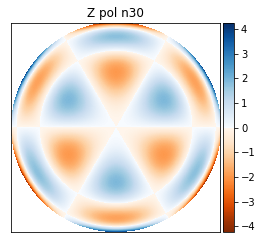

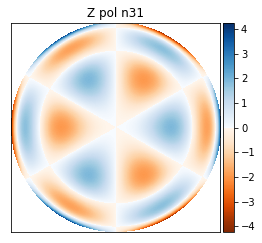

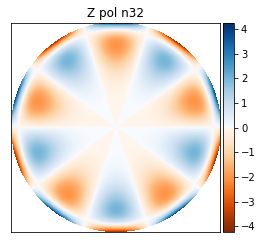

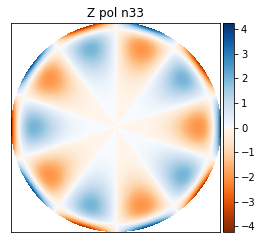

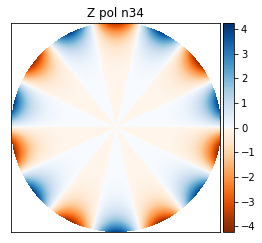

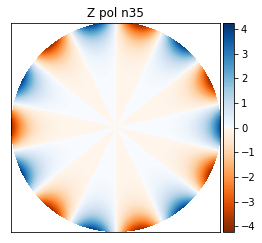

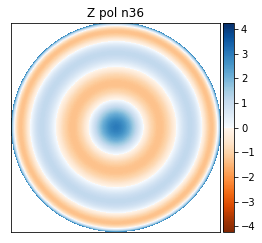

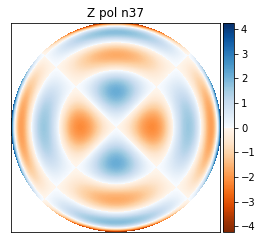

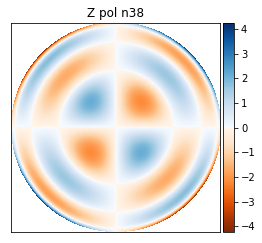

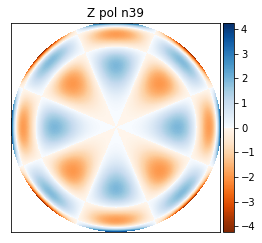

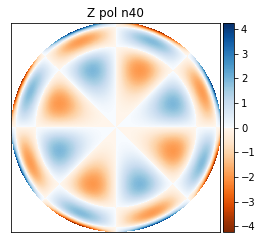

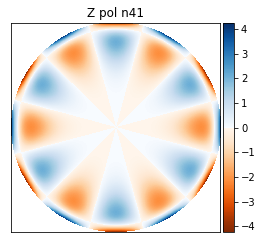

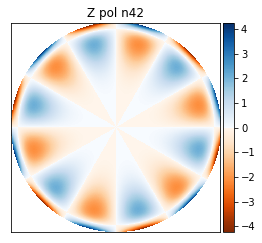

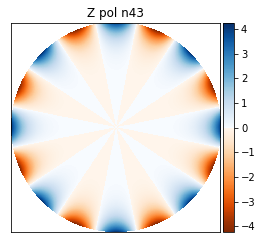

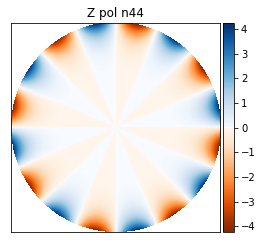

In [6]:
zernikes = []

decim_f = 16 # Gives 1024/8 = 128 per dimension

for it in range(45):
    
#     zernikes.append(resize_im(Zcube['Zpols'][0,it][5], decim_f))
    zernikes.append(Zcube['Zpols'][0,it][5])

    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(111)
    im1 = ax1.imshow(zernikes[it], cmap=newcmp, interpolation='None', vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_title('Z pol n%d'%(it))
    ax1.set_xticks([]);ax1.set_yticks([])
    plt.show()
    

# Build PSFs as a function of the Zernike polynomials

The Zernike polynomials are used to model the wavefront phase $\large \Phi(\rho, \theta)$. So we will model the phase function $\large \Phi$ as a Zernike series:
$$ \large \Phi(\rho, \theta) = \sum_{i=1}^{N} a_i Z_i(\rho, \theta) $$ 

To reconstruct the PSF at the focal plane we need to have:

$$\large I(x,y) \sim \left| \mathcal{F}\left\{ P(\rho, \theta) \mathrm{e}^{2 \pi i \Phi(\rho, \theta) / \lambda} \right\} \right|^{2} $$

(For the moment I will be using _numpy_'s fft module. It could be replaced with _pyfftw_ that is faster)



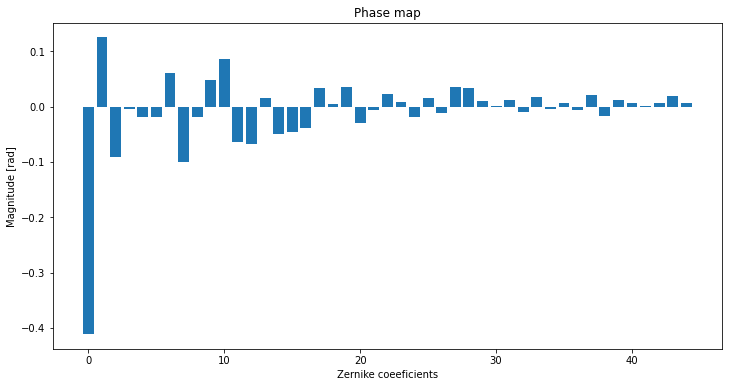

In [7]:
num_zer = 45
rand_a = []

for it in range(num_zer):
    rand_a.append((np.random.rand()-0.5)*2./(it+1))
    

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
im1 = ax1.bar(np.arange(len(rand_a)), np.array(rand_a))
ax1.set_title('Phase map')
ax1.set_xlabel('Zernike coeeficients')
ax1.set_ylabel('Magnitude [rad]')
plt.show()

In [8]:
# Create the phase with the Zernike basis
phase = 0

for it in range(num_zer):
#     rand_a.append(np.random.rand())
#     phase += Zcube['Zpols'][0,it][5]*rand_a[it]
    phase += zernikes[it]*rand_a[it]
    

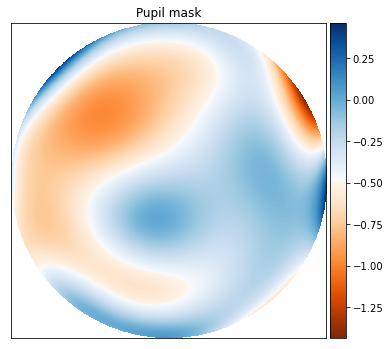

In [9]:

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
im1 = ax1.imshow(phase, cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('Pupil mask')
ax1.set_xticks([]);ax1.set_yticks([])
plt.show()


Original shape
(1024, 1024)
New shape
(64, 64)


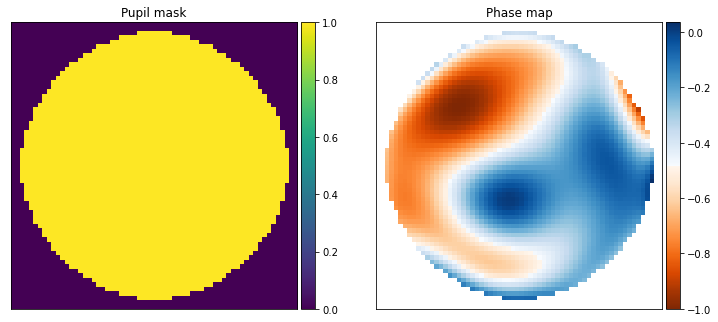

In [10]:
print('Original shape')
print(phase.shape)

decim_f = 16
phase = resize_im(phase, decim_f)

print('New shape')
print(phase.shape)

# Generate pupil mask
# pupil_mask = ~np.isnan(Zcube['Zpols'][0,1][5])
# pupil_mask = ~np.isnan(zernikes[1])
pupil_mask = ~np.isnan(phase)

# Normalize phase map
phase[pupil_mask] /= np.max(abs(phase[pupil_mask])) 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(pupil_mask, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('Pupil mask')
ax1.set_xticks([]);ax1.set_yticks([])

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(phase, cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Phase map')
ax2.set_xticks([]);ax2.set_yticks([])

plt.show()


In [11]:
np.sqrt(np.nanmean((phase - np.nanmean(phase))**2))


0.2647638

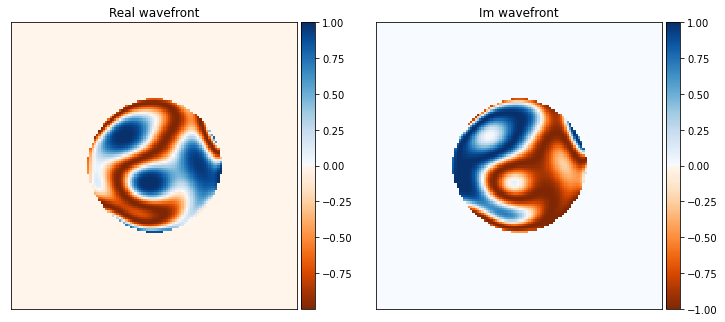

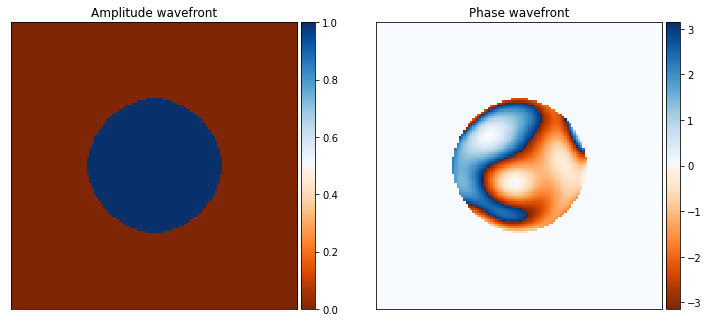

In [12]:
# Create the wavefront

# wavefront = np.zeros(phase.shape, dtype=np.complex128)
# wavefront[pupil_mask] = np.exp(2j*np.pi*phase[pupil_mask])

pad_factor = 2
start = (phase.shape[0]*pad_factor)//2 - phase.shape[0]//2
stop = (phase.shape[0]*pad_factor)//2 + phase.shape[0]//2
wavefront = np.zeros((phase.shape[0]*pad_factor, phase.shape[1]*pad_factor), dtype=np.complex128)
wavefront[start:stop, start:stop][pupil_mask] = np.exp(2j*np.pi*phase[pupil_mask])

    
# wavefront[pupil_mask] /= np.max(abs(wavefront[pupil_mask])) 

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(wavefront.real, cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title('Real wavefront')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(wavefront.imag, cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Im wavefront')
ax2.set_xticks([]);ax2.set_yticks([])

plt.show()


fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(abs(wavefront), cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title('Amplitude wavefront')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(np.angle(wavefront), cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Phase wavefront')
ax2.set_xticks([]);ax2.set_yticks([])

plt.show()


In [13]:


fft_wavefront = np.fft.fftshift(np.fft.fft2(wavefront))
psf = np.abs(fft_wavefront)**2

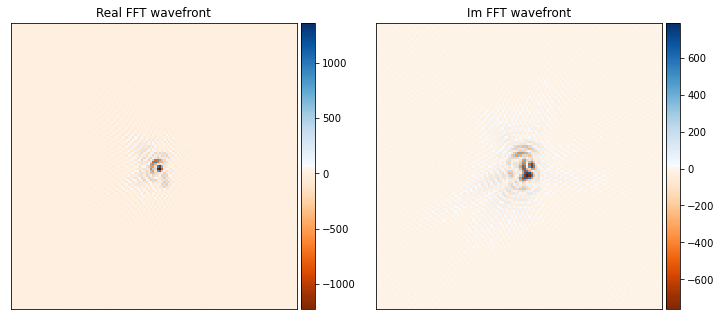

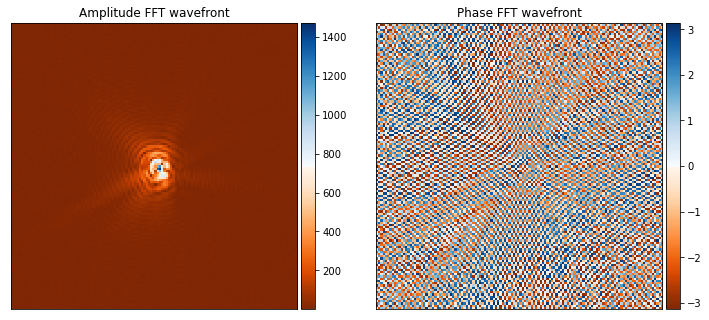

In [14]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(fft_wavefront.real, cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title('Real FFT wavefront')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(fft_wavefront.imag, cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Im FFT wavefront')
ax2.set_xticks([]);ax2.set_yticks([])

plt.show()


fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(abs(fft_wavefront), cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title('Amplitude FFT wavefront')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(np.angle(fft_wavefront), cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Phase FFT wavefront')
ax2.set_xticks([]);ax2.set_yticks([])

plt.show()



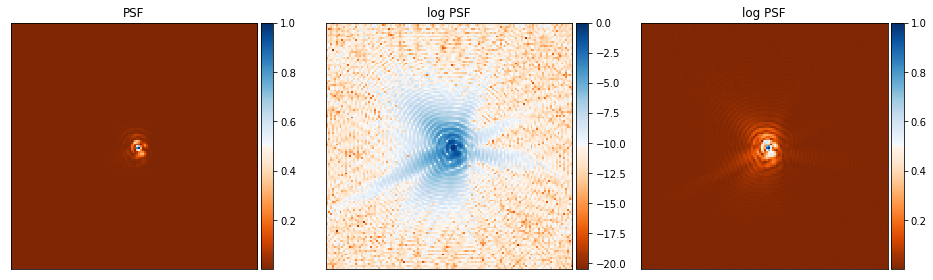

In [15]:

# Normalize the PSF
psf /= np.max(abs(psf))


fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(psf, cmap=newcmp, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xticks([]);ax1.set_yticks([])
ax1.set_title('PSF')

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(np.log(psf), cmap=newcmp, interpolation='None')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('log PSF')
ax2.set_xticks([]);ax2.set_yticks([])

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(np.sqrt(psf), cmap=newcmp, interpolation='None')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('log PSF')
ax3.set_xticks([]);ax3.set_yticks([])

plt.show()



In [38]:

class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    decim_f=16
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, decim_f=16, pad_factor=2, max_order=45, max_wfe=0.1,
                 lambda_norm=0.550, rand_seed=None, plot_opt=False):
        # Input attributes
        self.pad_factor = pad_factor
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.decim_f = decim_f
        self.max_wfe = max_wfe
        self.lambda_norm = lambda_norm
        
        # Class attributes
        self.rand_coeffs = None
        self.psf = None
        self.wf = None
        self.phase = None
        self.pupil_mask = None
        self.lambda_obs = None
        

    @staticmethod
    def fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern'):
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])

        plt.show()
    
    @staticmethod
    def wf_phase_plotter(pupil_mask, wf, phase, lambda_obs, cmap='viridis'):
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(wf, cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('WF map [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('Phase map [rad] (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])

        plt.show()
        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

    def plot_psf(self, cmap='gist_stern'):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap)
        else:
            print('No PSF has been computed yet.')
        
    def plot_wf_phase(self, cmap='viridis'):
        if self.wf is not None:
            self.wf_phase_plotter(self.pupil_mask, self.wf, self.phase, self.lambda_obs, cmap)
        else:
            print('No WF has been computed yet.')

    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        rand_coeffs = []

        for it in range(max_order):
            rand_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.rand_coeffs = rand_coeffs

    def plot_rand_coeffs(self):
        """Plot random Zernike coefficients."""
        if self.rand_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.rand_coeffs)), np.array(self.rand_coeffs))
            ax1.set_title('Phase map')
            ax1.set_xlabel('Zernike coeeficients')
            ax1.set_ylabel('Magnitude [rad]')
            plt.show()
        else:
            print('Random coeffs not generated.')
            
    def get_rand_coeffs(self):
        """Get random coefficients"""
        if self.rand_coeffs is not None:
            return self.rand_coeffs
        else:
            print('Random coeffs not generated.')
        

    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False):
        """Generate monochromatic PSF."""
        self.lambda_obs = lambda_obs
        
        if self.rand_coeffs is None or regen_sample is True:
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            if self.plot_opt:
                self.plot_rand_coeffs()
            rand_coeffs = self.get_rand_coeffs()
        else:
            rand_coeffs = self.get_rand_coeffs()
        
        
        # Create the phase with the Zernike basis
        wf = 0
        for it in range(self.max_order):
            wf += self.zernike_maps[it]*rand_coeffs[it]
        
        # Decimate image
        wf = self.decimate_im(wf, self.decim_f)


        # Generate pupil mask
        self.pupil_mask = ~np.isnan(wf)

        # Normalize wfe map
        wfe = np.sqrt(np.mean((wf[self.pupil_mask] -np.mean(wf[self.pupil_mask]))**2))
        mult_factor = (self.max_wfe * self.lambda_norm) / wfe
        wf[self.pupil_mask] *= mult_factor
        
        # Save the wavefront
        self.wf = wf
        
        
        # Generate the full phase
        self.phase = np.zeros(wf.shape, dtype=np.complex128)
        self.phase[self.pupil_mask] = np.exp(2j*np.pi*wf[self.pupil_mask]/self.lambda_obs)
        
        # Apply the diffraction operator
        self.psf = self.fft_diffraction_op(self.phase, self.pupil_mask, self.pad_factor)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)
     
    @staticmethod
    def gen_SED_interp(SED, n_bins=35):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind='quadratic')
        
        return wvlength, SED_interp
    
    def generate_poly_PSF(self, SED, n_bins=35, regen_sample=False):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        if self.rand_coeffs is None or regen_sample is True:
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            if self.plot_opt:
                self.plot_rand_coeffs()
            rand_coeffs = self.get_rand_coeffs()
        else:
            rand_coeffs = self.get_rand_coeffs()
    
        # Generate SED interpolator and wavelengtyh array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(wvlength)
        SED_norm /= np.sum(SED_norm)
        
        stacked_psf = 0
        
        for it in range(wvlength.shape[0]):
            
            wvl_um = wvlength[it]/1e3
            SED_T = SED_norm[it]
            
            self.generate_mono_PSF(lambda_obs=wvl_um)
            stacked_psf += self.get_psf()*SED_T
            
#         stacked_psf /= wvlength.shape[0]
        
        return stacked_psf
        
    

In [22]:

sim_psf_toolkit = SimPSFToolkit(zernike_maps=zernikes ,plot_opt=True)


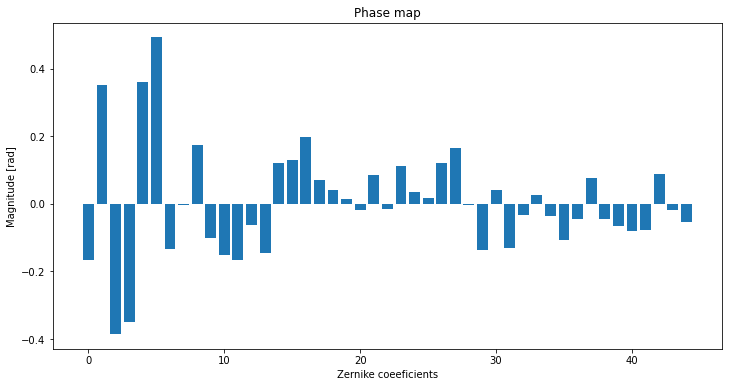

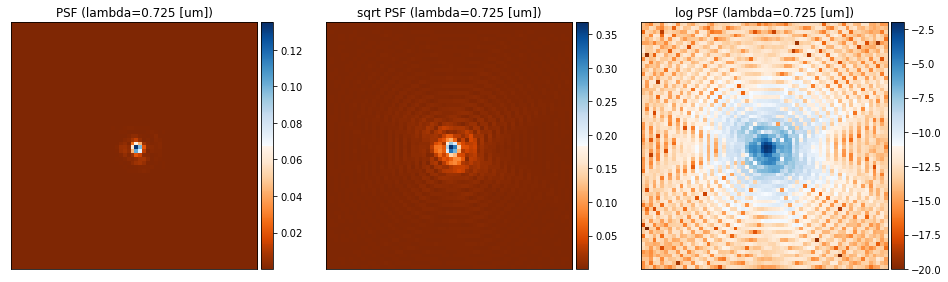

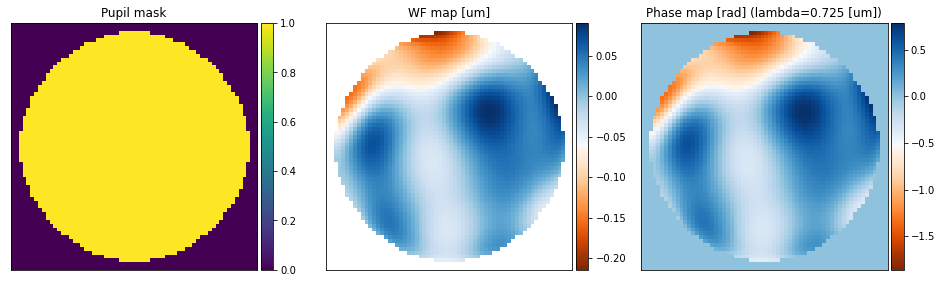

In [23]:
sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.725)
psf_725 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf(cmap=newcmp)
sim_psf_toolkit.plot_wf_phase(cmap=newcmp)


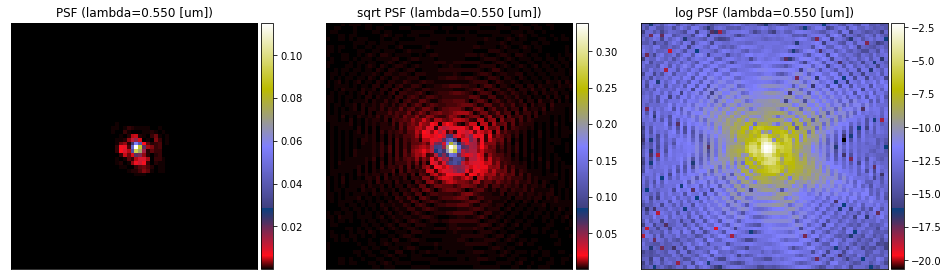

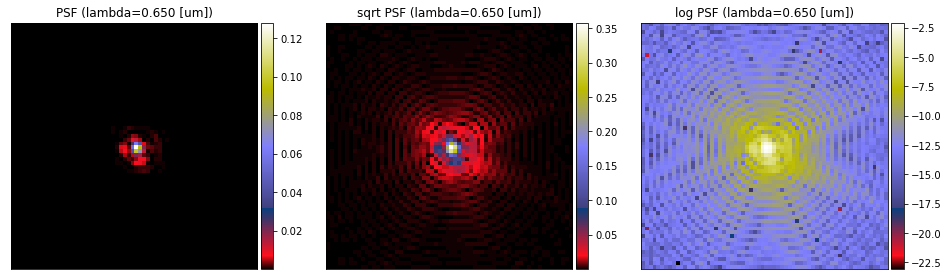

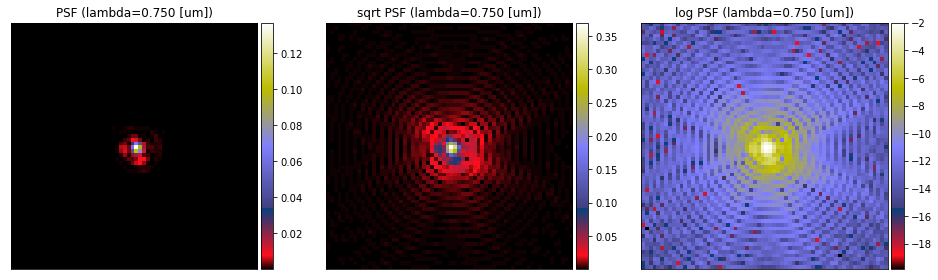

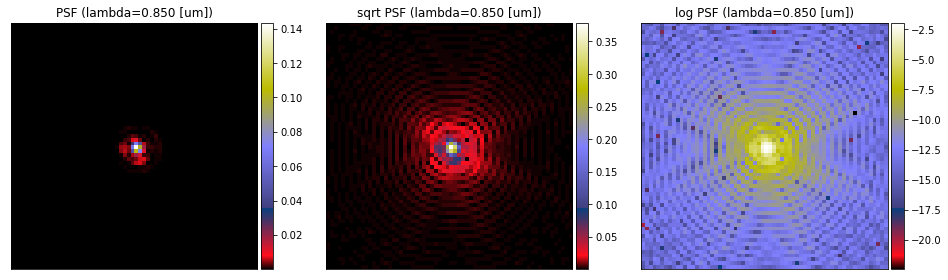

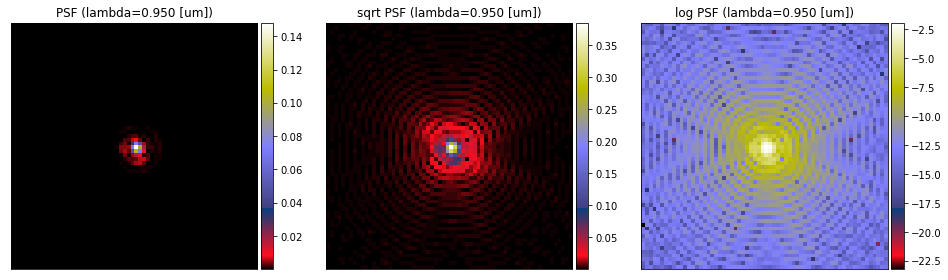

In [24]:
sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.550)
psf_550 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.650)
psf_650 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.750)
psf_750 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.850)
psf_850 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.950)
psf_950 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()


In [25]:
res_psf = psf_850 - psf_550

In [26]:
np.sum(psf_850)

1.0

In [27]:
np.sum(res_psf)

6.765421556309548e-17

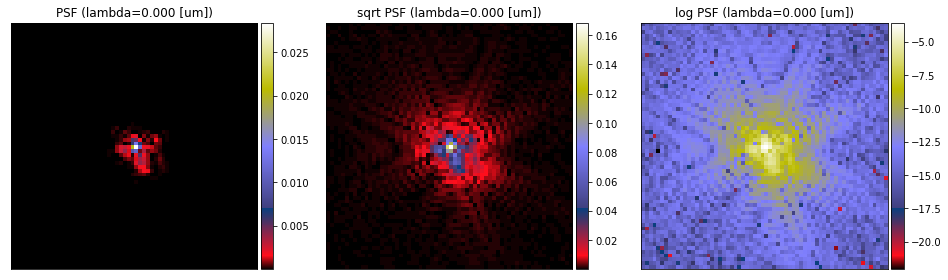

In [28]:


sim_psf_toolkit.psf_plotter(abs(res_psf), lambda_obs=0.000)



In [32]:
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/templatesCOSMOS/SB1_A_0_UV.sed'
PA_SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/example_TSED.txt'

In [33]:
my_data = np.genfromtxt(SED_path,dtype=np.dtype('float64'))

In [ ]:
PA_SED = np.genfromtxt(PA_SED_path,dtype=np.dtype('float64'))
PA_wvlength = np.arange(351)+550
PA_SED_wv = np.concatenate((PA_wvlength.reshape(-1,1), PA_SED.reshape(-1,1)), axis=1)


In [ ]:

euclid_band = np.copy(my_data)
euclid_band = euclid_band[euclid_band[:,0]>=500,:]
euclid_band = euclid_band[euclid_band[:,0]<=950,:]

# euclid_band[:,1] /= np.sum(euclid_band[:,1])
# PA_SED_wv[:,1] /= np.sum(PA_SED_wv[:,1])

# print(np.sum(PA_SED_wv[:,1]))
# print(np.sum(euclid_band[:,1]))
# print(np.sum(my_data[:,1]))

euclid_sed_interp = sp.interpolate.interp1d(
    euclid_band[:,0], euclid_band[:,1], kind='quadratic', bounds_error=False, assume_sorted=True)
PA_sed_interp = sp.interpolate.interp1d(
    PA_SED_wv[:,0], PA_SED_wv[:,1], kind='quadratic', bounds_error=False, assume_sorted=True)




In [ ]:
n_bins = 70
wv_max = 900
wv_min = 550

wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))

# wvlength = np.arange(351)+550

euclid_SED_T = euclid_sed_interp(wvlength)
euclid_SED_T /= np.sum(euclid_SED_T)

PA_SED_T = PA_sed_interp(wvlength)
PA_SED_T /= np.sum(PA_SED_T)



plt.figure(figsize=(14,6))
plt.plot(wvlength, euclid_SED_T, '-', label='COSMOS SED')
plt.plot(wvlength, PA_SED_T, '-', label='PA SED')
plt.legend()
plt.show()


plt.figure(figsize=(14,6))
plt.plot(euclid_band[:,0], euclid_band[:,1], '-', label='COSMOS SED')
plt.plot(PA_SED_wv[:,0], PA_SED_wv[:,1], '-', label='PA SED')
plt.legend()
plt.show()



In [ ]:

sim_psf_toolkit = SimPSFToolkit(zernike_maps=zernikes ,plot_opt=True)



In [ ]:
sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.725)
psf_725 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf(cmap=newcmp)
sim_psf_toolkit.plot_wf_phase(cmap=newcmp)

In [39]:
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/templatesCOSMOS/SB1_A_0_UV.sed'
PA_SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/example_TSED.txt'


PA_SED = np.genfromtxt(PA_SED_path,dtype=np.dtype('float64'))
PA_wvlength = np.arange(351)+550
PA_SED_wv = np.concatenate((PA_wvlength.reshape(-1,1), PA_SED.reshape(-1,1)), axis=1)


In [40]:
poly_psf = sim_psf_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=35)


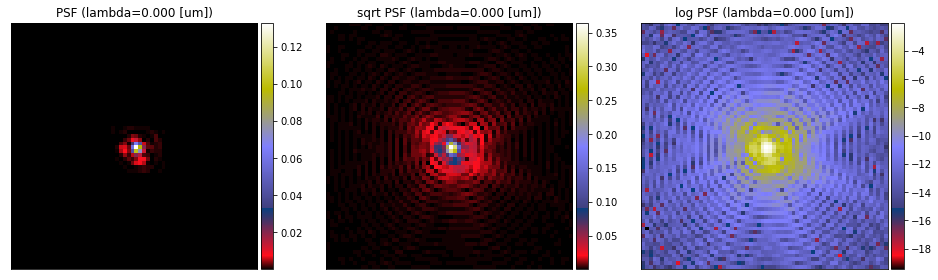

In [41]:
sim_psf_toolkit.psf_plotter(poly_psf, lambda_obs=0.000, cmap='gist_stern')


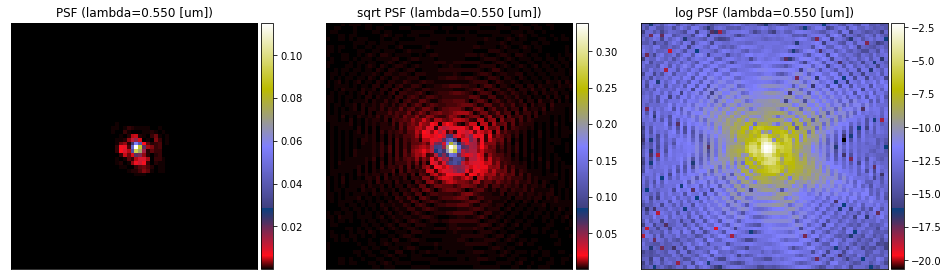

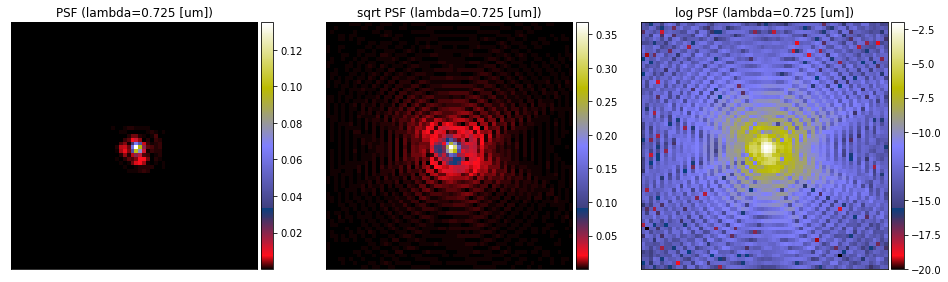

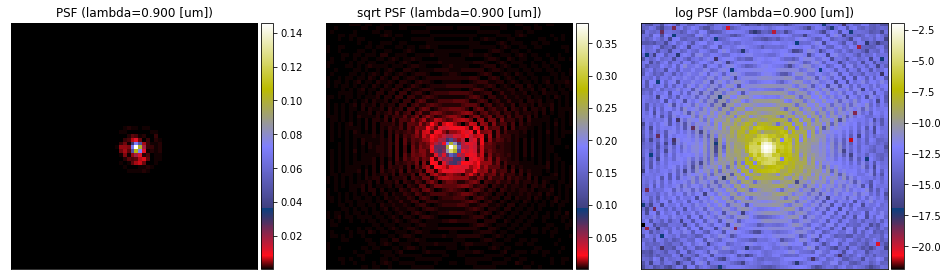

In [42]:
sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.550)
psf_550 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.725)
psf_725 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()

sim_psf_toolkit.generate_mono_PSF(lambda_obs=0.900)
psf_900 = sim_psf_toolkit.get_psf()
sim_psf_toolkit.plot_psf()